In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.distributions import Dirichlet, Bernoulli, Uniform
import pandas as pd
import tqdm as tm

from src.alignment import *
from src.RGD import *
from src.model_gen import *
from src.visualize_latent_space import *

# from sklearn.decomposition import TruncatedSVD as psvd
# import plotly.express as px
# from torch import nn
# from torch.utils.data import DataLoader
# from torchvision import datasets
# from torchvision.transforms import ToTensor
# from numpy import random as rd
# from numpy import arange as seq
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
#########################################################################################################################################################################
#########################################################################################################################################################################
#########################################################################################################################################################################
#For easier simulation
#########################################################################################################################################################################
#########################################################################################################################################################################
#########################################################################################################################################################################
class PAIRs:
    def __init__(self, settings, oracle = False, two_crutch = False, no_crutch = False):
 
        self.settings = settings
        self.initialization = settings.rand_initialization

        self.lat_0 = init_Z(self.settings)
        self.adj_0 = gen_Y(self.lat_0)

        self.lat_1 = next_Z(self.adj_0, self.lat_0, self.settings)
        self.adj_1 = gen_Y(self.lat_1)

        #the oracle stuff
        if oracle:
            self.pred_ora = gen_X(Y = self.adj_0, 
                                Z = self.lat_0)
            self.resp_ora = self.lat_1


        #the two-crutch stuff
        if two_crutch:
            lat_cru_0 = orthogonal_procrustes(reference=self.lat_0,
                                              need_embed_align=self.adj_0,
                                              dim = (self.settings.latent_space_dim - 1))
            self.pred_cru = gen_X(Y = self.adj_0, 
                                  Z = lat_cru_0)
            self.resp_cru = orthogonal_procrustes(reference = self.lat_1,
                                                  need_embed_align = self.adj_1,
                                                  dim = (self.settings.latent_space_dim - 1))
        
        #the convalescent stuff
        if no_crutch:
            lat_con_0 = GD_RDPG(self.adj_0, 
                                    X = self.initialization,
                                    L = 40)
            self.pred_noc = gen_X(Y = self.adj_0, 
                                Z = lat_con_0)
            self.resp_noc = GD_RDPG(self.adj_1,
                                    X = lat_con_0, 
                                    L = 40)


In [3]:
#########################################################################################################################################################################
#########################################################################################################################################################################
#########################################################################################################################################################################
#Actual simulation
#########################################################################################################################################################################
#########################################################################################################################################################################
#########################################################################################################################################################################

def dir_reg_simulation(number_of_nodes, cs = current_settings):

    non_specifics = ["seed", "nodes", "cru_2_info_lost", "cru_0_info_lost"]
    
    b_len = cs.constraint.shape[1]

    actual_beta = ["beta_"+ str(i) + "_real" for i in range(1,(b_len+1))]

    L_oracle = ["L_" + "ora_" + "beta_" + str(i) + "_est" for i in range(1,b_len)]
    L_cru_2  = ["L_" + "cru_2_" + "beta_" + str(i) + "_est" for i in range(1,b_len)]
    L_cru_0  = ["L_" + "cru_0_" + "beta_" + str(i) + "_est" for i in range(1,b_len)]

    oracle_beta_est = ["ora_" + "beta_"+ str(i) + "_est" for i in range(1,(b_len+1))]
    cru_2_beta_est = ["cru_2_" + "beta_" + str(i) + "_est" for i in range(1,(b_len+1))]
    cru_0_beta_est = ["cru_0_" + "beta_" + str(i) + "_est" for i in range(1,(b_len+1))]

    oracle_fish_est = ["oracle_" + "fish_" + str(i) + "_est" for i in range(1, (b_len)**2+1)]
    cru_2_fish_est = ["cru_2_" + "fish_" + str(i) + "_est" for i in range(1, (b_len)**2+1)]
    cru_0_fish_est = ["cru_0_" + "fish_" + str(i) + "_est" for i in range(1, (b_len)**2+1)]

    colnames = non_specifics + actual_beta + L_oracle + L_cru_2 + L_cru_0 + oracle_beta_est + cru_2_beta_est + cru_0_beta_est + oracle_fish_est + cru_2_fish_est + cru_0_fish_est
    df = pd.DataFrame(columns= colnames)
    b = cs.parameter_vec
    B = cs.parameter_mat

    for i in tm.tqdm(range(len(number_of_nodes)), desc = "Processing", unit = "iteration"):
    # for i range(len(number_of_nodes)): #the version without progress bar
        torch.manual_seed(i)
        constraint = cs.constraint
        n = number_of_nodes[i]
        cs.change_node(n)

        temp = PAIRs(settings = current_settings, oracle = True, two_crutch = True, no_crutch = True)

        po = temp.pred_ora
        ro = temp.resp_ora
        pc = temp.pred_cru
        rc = temp.resp_cru
        pn = temp.pred_noc
        rn = temp.resp_noc

        oracle_results = Dir_NGD(po, ro, B, cs = cs)
        cru_2_results = Dir_NGD(pc, rc, B, cs = cs)
        cru_0_results = Dir_NGD(pn, rn, B,  cs =cs)

        L_oracle_result = Dir_Linear_Initialization(po, ro)[:3]
        L_cru_2_result = Dir_Linear_Initialization(pc, rc)[:3]
        L_cru_0_result = Dir_Linear_Initialization(pn, rn)[:3]

        oracle_beta_est_ = proj_beta(oracle_results["final_estimate"], constraint.to("cpu"))
        cru_2_beta_est_ = proj_beta(cru_2_results["final_estimate"], constraint.to("cpu"))
        cru_0_beta_est_ = proj_beta(cru_0_results["final_estimate"], constraint.to("cpu"))

        oracle_fish_est_ = oracle_results["final_fisher_info"].reshape(-1)
        cru_2_fish_est_ = cru_2_results["final_fisher_info"].reshape(-1)
        cru_0_fish_est_ = cru_0_results["final_fisher_info"].reshape(-1)

        temp = torch.cat((torch.tensor([i, n, cru_2_results["ASE_info_lost"], cru_0_results["ASE_info_lost"]], dtype = float),
                          b,
                          L_oracle_result, 
                          L_cru_2_result,
                          L_cru_0_result,
                          oracle_beta_est_, 
                          cru_2_beta_est_,
                          cru_0_beta_est_, 
                          oracle_fish_est_,
                          cru_2_fish_est_,
                          cru_0_fish_est_), dim = 0).numpy()
        temp = pd.DataFrame(temp).T
        temp.columns = colnames
        df = pd.concat([df, temp], ignore_index= True)
    return(df) 

In [4]:
current_settings.change_node(9000)
cs = current_settings
C = cs.constraint
B = cs.parameter_mat
b = cs.parameter_vec

temp = PAIRs(settings = cs, oracle = True, two_crutch = False, no_crutch = False)
po = temp.pred_ora
ro = temp.resp_ora
# B_init = Dir_Linear_Initialization(po, ro)
# cs.change_parameter_vec(B_init)
C = cs.constraint
B = cs.parameter_mat
b = cs.parameter_vec

cs.change_constraint(False)
results_no_c = Dir_NGD(po, ro, B, cs = cs)

cs.change_constraint(True)
results_yes_c = Dir_NGD(po, ro, B, cs = cs)

In [5]:
proj_beta(results_no_c["final_estimate"], C) , proj_beta(results_yes_c["final_estimate"],C)

(tensor([ 0.9931,  0.9860, -4.0395,  5.1101]),
 tensor([ 0.9951,  0.9973, -4.0126,  5.0006]))

In [6]:
X1 = po[1,].unsqueeze(dim = 1)
X1.T @ B, torch.kron(X1.T, torch.eye(3)) @ B.reshape(-1)

(tensor([[3.1361, 3.4251, 6.4388]]), tensor([3.1361, 3.4251, 6.4388]))

In [10]:
# #########################################################################################################################################################################
# #########################################################################################################################################################################
# #########################################################################################################################################################################
# #Actual simulation DUPE
# #########################################################################################################################################################################
# #########################################################################################################################################################################
# #########################################################################################################################################################################



In [8]:
mat = torch.tensor([[1,1,10], [1,10,1], [10,1,1]], dtype= torch.float).reshape(K, p)  #starting parameters for latent position
# mat = torch.tensor([[36,2,27], [99,86,14], [72,18,34]], dtype= torch.float).reshape(K, p)/10
current_settings.change_init_distr(mat)


number_of_nodes = np.tile([1500, 3000, 4500, 6000, 7500, 9000, 10500, 12000], 1)
simulation_results = dir_reg_simulation(number_of_nodes, cs = current_settings)
simulation_results.to_csv(r"C:\Users\yangs\Desktop\simulation_results_0317.csv", index = False)

Processing:   0%|          | 0/8 [00:00<?, ?iteration/s]C:\Users\yangs\AppData\Local\Temp\ipykernel_27692\2074621919.py:79: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, temp], ignore_index= True)
Processing: 100%|██████████| 8/8 [01:14<00:00,  9.33s/iteration]


In [16]:
# starting_lat_parameter_mat = torch.tensor([[1,1,10], [1,10,1], [10,1,1]], dtype= torch.float).reshape(K, p)  #starting parameters for latent position
# # starting_lat_parameter_mat = torch.tensor([[36,2,27], [99,86,14], [72,18,34]], dtype= torch.float).reshape(K, p)/10
# current_settings.change_init_distr(starting_lat_parameter_mat)
# current_settings.change_node(3000)


# n = current_settings.nodes
# Z0 = init_Z(current_settings)
# Y0 = gen_Y(Z0)

# init_dist = Uniform(0.2,0.8)
# init_samp = init_dist.sample((n*K,)).reshape(n, 3)
# # init_dist = Dirichlet(torch.tensor([[ 1.,  1., 10], [ 1., 10,  1.], [10,  1.,  1.]]))
# # init_samp = init_dist.sample((int(n/K),)).reshape(n, K)

# raw_ASE_0 = ASE(Y0, 2)
# # standard = torch.kron(torch.eye(3), torch.ones(int(n/K))).T
# # # std_dist = Dirichlet(torch.tensor([[36,2,27], [99,86,14], [72,18,34]], dtype= torch.float))
# # # standard = std_dist.sample((int(n/K),)).reshape(n, K)
# # std_align = orthogonal_procrustes(standard, raw_ASE_0, 2)

# GD_est_0 = GD_RDPG(Y0, raw_ASE_0, 40, tol = 0.001)
# Procrustes_est_0 = orthogonal_procrustes(Z0, Y0, 2)

# Z1 = next_Z(Y0, Z0, current_settings)
# Y1 = gen_Y(Z1)
# GD_est_1 = GD_RDPG(Y1, GD_est_0[:,:2], 20, tol = 0.01)
# # GD_est_1 = GD_RDPG(Y1, Z0, tol = 0.01)
# Procrustes_est_1 = orthogonal_procrustes(Z1, Y1, 2)



# lat_vis(raw_ASE_0, -1, col = "green")
# lat_vis(Z0, -1, col = "green")
# lat_vis(GD_est_0, -1, col = "red")
# lat_vis(Procrustes_est_0, -1, col = "blue")


# lat_vis(GD_est_1, -0.1, col = "red")
# lat_vis(Z1, -0.1, col = "blue")

Simulation for the Riemannian GD

In [7]:
# A = torch.tensor([[1,1,10], [1,10,1], [10,1,1]], dtype= torch.float).reshape(K, 3)  #starting parameters for latent position
N, n, p, K = 2, 15000, 4, 3
A = torch.tensor([[1, 1, 10, 1], [1, 10, 1, 1], [10, 1, 1, 1]], dtype= torch.float).reshape(K, p)  #starting parameters for latent position
# A = torch.tensor([[36,2,27, 15], [99,86,14, 66], [72,18,34, 88]], dtype= torch.float).reshape(K, p)/10  #starting parameters for latent position
current_settings = Settings(time = N,
                nodes = n,
                latent_space_dim = p,
                groups = K, 
                parameter_vec = torch.tensor([1,1,-4,5.0]),
                starting_lat_parameter_mat = A,
                constraint = True)

temp = PAIRs(settings = current_settings, oracle = True, two_crutch = True, no_crutch = False)
t1 = temp.lat_0
t2 = temp.pred_cru
t3 = ASE(temp.adj_0, p-1)
# t1 = temp.lat_1
# t2 = temp.resp_cru
# t3 = ASE(temp.adj_1, p-1)


In [8]:
GD_result = Op_Riemannian_GD(t3, "softplus", 60)
R = GD_result.align_mat

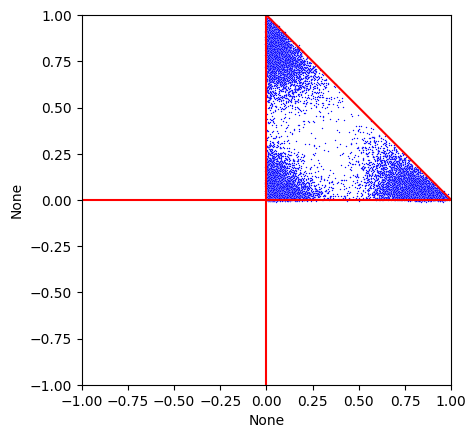

In [9]:
lat_vis(t2, -1, "blue")
# lat_vis(t3, -1, "red")

In [10]:
lat_vis_3d(t3 @ R, t2, -1)

In [ ]:
GD_result = Op_Riemannian_GD(t3, "softplus")
R = GD_result.GD_one_step(torch.eye(p-1), 1)
GD_result.update_parameter(50, 0.1)

total_iter = 50500
tracking_gradient = []
tracking_loss = []

iteration = 50000
while iteration <= total_iter:
    R = GD_result.GD_one_step(R, 1/25000)
    tracking_gradient.append(torch.norm(GD_result.deriv_W_relu(R)))
    tracking_loss.append(GD_result.simplex_loss_relu(t3 @ R))
    iteration += 1
sns.scatterplot(x = range(len(tracking_loss)), y = np.log(np.array(tracking_loss)), s = 0.5)
sns.scatterplot(x = range(len(tracking_gradient)), y = np.log(np.array(tracking_gradient)), s = 0.5)